<a href="https://colab.research.google.com/github/shengjiyang/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes',
                      'Location',
                      'Reviewer',
                      'Address',
                      'URL',
                      'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [61]:
df.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great'],
      dtype='object')

In [62]:
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [63]:
# In order to make the Great column easier to work with,
# I have converted the boolean values to integers

df.Great = df.Great.astype(int)
df.Great

0      0
1      0
2      0
3      0
4      1
      ..
418    0
419    1
420    0
421    1
422    1
Name: Great, Length: 421, dtype: int64

In [64]:
# Courtesy of Connor Clark

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'])
df = df.sort_index()
df = df.drop(columns = ['Date'])

df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-16,Other,NaN,NaN,NaN,8.00,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,3.0,2.0,3.0,2.0,3.0,2.0,x,NaN,x,x,x,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-04-20,Other,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,5.0,5.0,4.0,5.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2016-01-18,California,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-24,Asada,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-24,California,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [65]:
# Courtesy of Tyler Etheridge

# Create dates for split conditions
import datetime
split_date_1 = datetime.datetime(2017, 1, 1)
split_date_2 = datetime.datetime(2018, 1, 1)

# 2016 and earlier = train
# 2017             = validation
# 2018             = test
train = df[df.index < split_date_1]
val = df[df.index >= split_date_1]
val = val[val.index < split_date_2]
test = df[df.index >= split_date_2]

train

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-16,Other,NaN,NaN,NaN,8.00,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,3.0,2.0,3.0,2.0,3.0,2.0,x,NaN,x,x,x,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-04-20,Other,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,5.0,5.0,4.0,5.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2016-01-18,California,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-24,Asada,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-01-24,California,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-02,California,4.0,4.3,NaN,5.65,3.0,NaN,NaN,19.5,22.0,0.75,4.0,1.5,2.0,3.0,4.2,4.0,3.0,2.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-12-02,Other,NaN,NaN,NaN,5.49,3.0,NaN,NaN,19.0,20.5,0.64,4.5,5.0,2.0,2.0,2.5,3.5,3.0,2.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2016-12-10,California,3.5,3.7,NaN,7.75,4.0,NaN,NaN,20.0,21.0,0.70,3.5,2.5,3.0,3.3,1.4,2.3,2.2,3.3,4.5,NaN,NaN,X,X,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [66]:
val

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,California,NaN,NaN,NaN,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2017-01-04,Other,NaN,NaN,NaN,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2017-01-07,Other,NaN,NaN,NaN,8.50,3.9,NaN,NaN,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2017-01-07,Other,NaN,NaN,NaN,7.90,4.0,NaN,NaN,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2017-01-10,Other,NaN,NaN,NaN,4.99,3.5,NaN,NaN,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-05,California,NaN,NaN,NaN,6.85,3.5,NaN,NaN,22.5,22.5,0.91,3.0,4.5,3.8,3.8,4.0,3.5,3.5,4.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-09-05,California,NaN,NaN,NaN,6.85,3.5,NaN,NaN,22.2,22.5,0.89,3.0,4.5,4.0,4.0,4.5,3.0,4.0,4.00,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-12-16,Other,4.0,4.5,Yes,11.50,3.5,NaN,NaN,15.0,25.0,0.75,2.0,2.0,4.0,3.5,3.0,4.5,3.5,4.00,2.0,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [67]:
test

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,California,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-01-09,Other,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-01-12,Other,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-01-12,California,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-04-04,Asada,NaN,NaN,NaN,7.20,3.0,NaN,NaN,24.50,22.7,1.00,4.0,5.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-04-09,Carnitas,NaN,NaN,NaN,5.99,2.0,NaN,NaN,19.00,24.5,0.91,2.0,3.5,4.5,4.0,4.0,2.0,3.0,4.0,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-04-09,Carnitas,NaN,NaN,NaN,5.99,3.5,NaN,NaN,17.50,24.0,0.80,4.0,4.5,5.0,4.5,5.0,4.0,4.0,4.5,4.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-04-09,Carnitas,NaN,NaN,NaN,5.99,3.0,NaN,NaN,20.00,23.0,0.84,3.5,5.0,4.3,3.5,5.0,4.0,3.0,3.8,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-04-14,California,NaN,NaN,NaN,8.99,4.0,NaN,NaN,25.00,23.0,1.05,4.5,4.5,4.0,4.0,3.0,4.0,3.5,4.0,3.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [74]:
features = ["Cost", "Tortilla", "Temp", "Meat", "Fillings",
            "Meat:filling", "Uniformity", "Salsa", "Synergy", "Wrap"]

target = "Great"

# I have begun with a baseline for classifying the greatness of a burrito
y_train = train[target]
y_val = val[target]

# Burrito Greatness Ratio
# This totally deserves to be in a restraunt management textbook somewhere:)
y_train.value_counts(normalize = True)

0    0.590604
1    0.409396
Name: Great, dtype: float64

In [97]:
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
baseline_y_pred = [majority_class] * len(y_train)

print("Baseline Prediction\n")

# Now that I've got a handle on for loops,
# I need more practice with if, else, elif loops...
if y_pred[0] == 1:
  print("Great")
elif y_pred[0] == 0:
  print("Not Great")

baseline_accuracy = accuracy_score(y_train, baseline_y_pred)

print("Accuracy: ", round(baseline_accuracy * 100, 2), "%")

Baseline Prediction

Not Great
Accuracy:  59.06 %


In [168]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Performing Logistic Regression on the Data

X_train = train[features]
X_val = val[features]

# Imputation of missing values
imputer = SimpleImputer()

X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.fit_transform(X_val)

# Scaling of the values 
scaler = StandardScaler()

X_train_standard = scaler.fit_transform(X_train_imputed)
X_val_standard = scaler.fit_transform(X_val_imputed)

# Instantiation
log_reg = LogisticRegression()
log_reg.fit(X_train_standard, y_train)

y_pred = log_reg.predict(X_val_standard)
y_pred

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [169]:
# NOTE: I ran this first without standardizing the data,
# standardization boosted the accuracy by about 2%:)

# Now we need to just get those folks at scikitlearn to include a normalize = True
# parameter in LogisticRegression too, to make my life easier.

accuracy = accuracy_score(y_val, y_pred)

print("Logistic Regression")
print("\nValidation Accuracy: ", round(accuracy * 100, 2), "%")

print(f"\nThe validation accuracy is {round((accuracy - baseline_accuracy) * 100, 2)}% greater than the baseline accuracy,")
print("a confirmation that our model is indeed useful at predicting burrito greatness.")

Logistic Regression

Validation Accuracy:  89.41 %

The validation accuracy is 30.35% greater than the baseline accuracy,
a confirmation that our model is indeed useful at predicting burrito greatness.


In [175]:
# Extracting Coefficients
log_reg.coef_[0]

array([0.31182827, 0.6648979 , 0.62260329, 1.22620739, 1.1845077 ,
       1.29467988, 0.01846392, 0.30787499, 1.71841095, 0.2322439 ])

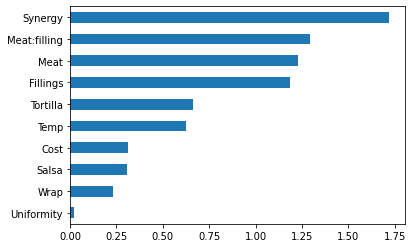

In [176]:
# Plotting Coefficients
import matplotlib.pyplot as plt
%matplotlib inline

coefficients = pd.Series(log_reg.coef_[0], df[features].columns)
coefficients.sort_values().plot.barh();

In [189]:
# Finally, to use the ***sacred test set*** to prove our model!

X_test = test[features]
y_test = test[target]

# Imputation of missing values
X_test_imputed = imputer.fit_transform(X_test)

# Scaling of the values 

X_test_standard = scaler.fit_transform(X_test_imputed)

test_pred = log_reg.predict(X_test_standard)

test_accuracy = accuracy_score(y_test, test_pred)

print("Test Accuracy: ", round(test_accuracy * 100, 2), "%")

print(f"\nThe validation accuracy is {-round((test_accuracy - accuracy) * 100, 2)}% less than the validation accuracy,")
print("showing that further research needs to be done in order to accurately")
print("predict burrito greatness.")

Test Accuracy:  68.42 %

The validation accuracy is 20.99% less than the validation accuracy,
showing that further research needs to be done in order to accurately
predict burrito greatness.


In [121]:
# Now to perform Logistic Regression with encoded categorical data...
categorical = df.select_dtypes(exclude='number').describe().T.sort_values(by='unique')
categorical

,count,unique,top,freq
Zucchini,1,1,x,1
Ham,2,1,x,2
Nopales,4,1,x,4
Lobster,1,1,x,1
Egg,5,1,x,5
Chile relleno,4,1,x,4
Bacon,3,1,x,3
Sushi,2,1,x,2
Unreliable,33,1,x,33
Avocado,13,1,x,13


In [124]:
cat_features = []

for element in categorical.index:
  cat_features.append(element)

cat_df = df[cat_features]
cat_df.columns

Index(['Zucchini', 'Ham', 'Nopales', 'Lobster', 'Egg', 'Chile relleno',
       'Bacon', 'Sushi', 'Unreliable', 'Avocado', 'Mushroom', 'Carrots',
       'Cabbage', 'Pineapple', 'Taquito', 'Onion', 'Cilantro', 'Salsa.1',
       'Sauce', 'Bell peper', 'Tomato', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Corn', 'Sour cream', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Pork', 'Chips', 'Burrito'],
      dtype='object')

In [126]:
# It appears that none of the above values' cardinality is too high to be encoded:)

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names = True)
df_encoded = encoder.fit_transform(cat_df)

df_encoded.head()

,Zucchini_nan,Zucchini_x,Ham_nan,Ham_x,Nopales_nan,Nopales_x,Lobster_nan,Lobster_x,Egg_nan,Egg_x,Chile relleno_nan,Chile relleno_x,Bacon_nan,Bacon_x,Sushi_nan,Sushi_x,Unreliable_x,Unreliable_nan,Avocado_nan,Avocado_x,Mushroom_nan,Mushroom_x,Carrots_nan,Carrots_x,Cabbage_nan,Cabbage_x,Cabbage_X,Pineapple_nan,Pineapple_x,Pineapple_X,Taquito_nan,Taquito_x,Taquito_X,Onion_nan,Onion_x,Onion_X,Cilantro_nan,Cilantro_x,Cilantro_X,Salsa.1_nan,...,Fries_nan,Fries_x,Fries_X,Corn_nan,Corn_x,Corn_X,Sour cream_x,Sour cream_nan,Sour cream_X,Chicken_nan,Chicken_x,Chicken_X,Shrimp_nan,Shrimp_x,Shrimp_X,Fish_nan,Fish_x,Fish_X,Rice_nan,Rice_x,Rice_X,Beans_nan,Beans_x,Beans_X,Lettuce_x,Lettuce_nan,Lettuce_X,Pork_nan,Pork_x,Pork_X,Chips_nan,Chips_x,Chips_X,Chips_Yes,Chips_No,Burrito_Other,Burrito_California,Burrito_Asada,Burrito_Carnitas,Burrito_Surf & Turf
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-16,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2015-04-20,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2016-01-18,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2016-01-24,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2016-01-24,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [133]:
# 2016 and earlier = train
# 2017             = validation
# 2018 and later   = test
cat_train = df_encoded[df_encoded.index < split_date_1]
cat_val = df_encoded[df_encoded.index >= split_date_1]
cat_val = cat_val[cat_val.index < split_date_2]
cat_test = df_encoded[df_encoded.index >= split_date_2]

cat_test

,Zucchini_nan,Zucchini_x,Ham_nan,Ham_x,Nopales_nan,Nopales_x,Lobster_nan,Lobster_x,Egg_nan,Egg_x,Chile relleno_nan,Chile relleno_x,Bacon_nan,Bacon_x,Sushi_nan,Sushi_x,Unreliable_x,Unreliable_nan,Avocado_nan,Avocado_x,Mushroom_nan,Mushroom_x,Carrots_nan,Carrots_x,Cabbage_nan,Cabbage_x,Cabbage_X,Pineapple_nan,Pineapple_x,Pineapple_X,Taquito_nan,Taquito_x,Taquito_X,Onion_nan,Onion_x,Onion_X,Cilantro_nan,Cilantro_x,Cilantro_X,Salsa.1_nan,...,Fries_nan,Fries_x,Fries_X,Corn_nan,Corn_x,Corn_X,Sour cream_x,Sour cream_nan,Sour cream_X,Chicken_nan,Chicken_x,Chicken_X,Shrimp_nan,Shrimp_x,Shrimp_X,Fish_nan,Fish_x,Fish_X,Rice_nan,Rice_x,Rice_X,Beans_nan,Beans_x,Beans_X,Lettuce_x,Lettuce_nan,Lettuce_X,Pork_nan,Pork_x,Pork_X,Chips_nan,Chips_x,Chips_X,Chips_Yes,Chips_No,Burrito_Other,Burrito_California,Burrito_Asada,Burrito_Carnitas,Burrito_Surf & Turf
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2018-01-09,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2018-01-12,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2018-01-12,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2018-04-04,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2018-04-09,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2018-04-09,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2018-04-09,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2018-04-14,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [134]:
cat_val

,Zucchini_nan,Zucchini_x,Ham_nan,Ham_x,Nopales_nan,Nopales_x,Lobster_nan,Lobster_x,Egg_nan,Egg_x,Chile relleno_nan,Chile relleno_x,Bacon_nan,Bacon_x,Sushi_nan,Sushi_x,Unreliable_x,Unreliable_nan,Avocado_nan,Avocado_x,Mushroom_nan,Mushroom_x,Carrots_nan,Carrots_x,Cabbage_nan,Cabbage_x,Cabbage_X,Pineapple_nan,Pineapple_x,Pineapple_X,Taquito_nan,Taquito_x,Taquito_X,Onion_nan,Onion_x,Onion_X,Cilantro_nan,Cilantro_x,Cilantro_X,Salsa.1_nan,...,Fries_nan,Fries_x,Fries_X,Corn_nan,Corn_x,Corn_X,Sour cream_x,Sour cream_nan,Sour cream_X,Chicken_nan,Chicken_x,Chicken_X,Shrimp_nan,Shrimp_x,Shrimp_X,Fish_nan,Fish_x,Fish_X,Rice_nan,Rice_x,Rice_X,Beans_nan,Beans_x,Beans_X,Lettuce_x,Lettuce_nan,Lettuce_X,Pork_nan,Pork_x,Pork_X,Chips_nan,Chips_x,Chips_X,Chips_Yes,Chips_No,Burrito_Other,Burrito_California,Burrito_Asada,Burrito_Carnitas,Burrito_Surf & Turf
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2017-01-04,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2017-01-07,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2017-01-07,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2017-01-10,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-05,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2017-09-05,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2017-12-16,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0


In [135]:
cat_test

,Zucchini_nan,Zucchini_x,Ham_nan,Ham_x,Nopales_nan,Nopales_x,Lobster_nan,Lobster_x,Egg_nan,Egg_x,Chile relleno_nan,Chile relleno_x,Bacon_nan,Bacon_x,Sushi_nan,Sushi_x,Unreliable_x,Unreliable_nan,Avocado_nan,Avocado_x,Mushroom_nan,Mushroom_x,Carrots_nan,Carrots_x,Cabbage_nan,Cabbage_x,Cabbage_X,Pineapple_nan,Pineapple_x,Pineapple_X,Taquito_nan,Taquito_x,Taquito_X,Onion_nan,Onion_x,Onion_X,Cilantro_nan,Cilantro_x,Cilantro_X,Salsa.1_nan,...,Fries_nan,Fries_x,Fries_X,Corn_nan,Corn_x,Corn_X,Sour cream_x,Sour cream_nan,Sour cream_X,Chicken_nan,Chicken_x,Chicken_X,Shrimp_nan,Shrimp_x,Shrimp_X,Fish_nan,Fish_x,Fish_X,Rice_nan,Rice_x,Rice_X,Beans_nan,Beans_x,Beans_X,Lettuce_x,Lettuce_nan,Lettuce_X,Pork_nan,Pork_x,Pork_X,Chips_nan,Chips_x,Chips_X,Chips_Yes,Chips_No,Burrito_Other,Burrito_California,Burrito_Asada,Burrito_Carnitas,Burrito_Surf & Turf
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2018-01-09,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2018-01-12,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2018-01-12,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2018-04-04,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2018-04-09,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2018-04-09,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2018-04-09,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2018-04-14,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [0]:
from sklearn.feature_selection import SelectKBest, chi2

ks = []
accuracy_scores = []

for k in range(1, len(X_train_encoded.columns) + 1):

  ks.append(k)

  selector = SelectKBest(score_func = chi2, k = k)
  X_train_selected = selector.fit_transform(cat_train, y_train)
  X_val_selected = selector.fit_transform(cat_val, y_val)

  model = LogisticRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_val_selected)

  accuracy = accuracy_score(y_val, y_pred)

  accuracy_scores.append(accuracy)

In [153]:
d = {'k' : ks, "Accuracy" : accuracy_scores}

SelectK = pd.DataFrame(d, columns = ["k", "Accuracy"])
print(SelectK.loc[SelectK.Accuracy == SelectK.Accuracy.max()])

     k  Accuracy
9   10  0.647059
10  11  0.647059
11  12  0.647059
12  13  0.647059


In [158]:
# Feature Selection

# Here I have chosen k = 9 as it is the lowest value with the
# highest accuracy.
selector = SelectKBest(score_func = chi2, k = 9)
X_train_selected = selector.fit_transform(cat_train, y_train)
X_val_selected = selector.fit_transform(cat_val, y_val)

(298, 9) (85, 9)


((298,), (85,))

In [177]:
### Which features were selected?
all_names = cat_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

selected_names

Index(['Unreliable_x', 'NonSD_x', 'Beef_x', 'Pico_x', 'Pico_X', 'Guac_x',
       'Guac_X', 'Cheese_x', 'Fries_x'],
      dtype='object')

In [0]:
# Logistic Regression

cat_log = LogisticRegression()
cat_log.fit(X_train_selected, y_train)

print(X_train_selected.shape, X_val_selected.shape)
y_train.shape, y_val.shape

In [160]:
cat_y_pred = cat_log.predict(X_val_selected)
cat_y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [190]:
cat_accuracy = accuracy_score(cat_y_pred, y_val)

print("Logistic Regression with Categorical Variables")
print("\nValidation Accuracy: ", round(cat_accuracy * 100, 2), "%")

print(f"\nThe validation accuracy is {round(-(cat_accuracy - baseline_accuracy) * 100, 2)} % less than the baseline accuracy.")
print("It seems that the sheer number of NaN values may have sunk this model's")
print("chances at predicting burrito greatness.")

print("\nThat being said, would it not be better to live in a world with slightly")
print("fewer not-so-great burritos?")

Logistic Regression with Categorical Variables

Validation Accuracy:  58.82 %

The validation accuracy is 0.24 % less than the baseline accuracy.
It seems that the sheer number of NaN values may have sunk this model's
chances at predicting burrito greatness.

That being said, would it not be better to live in a world with slightly
fewer not-so-great burritos?


In [180]:
# Extracting and Plotting Coefficients
cat_log.coef_

array([[ 1.6327488 , -0.21046034, -0.75997802, -0.14500812, -0.24070777,
        -0.58268413, -0.75995806, -1.00020386,  0.61191061]])

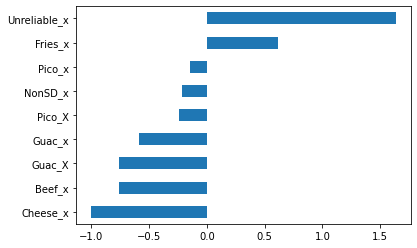

In [179]:
%matplotlib inline

coefficients = pd.Series(cat_log.coef_[0], selected_names)
coefficients.sort_values().plot.barh();

In [198]:
# Now to test our categorical model against the ***sacred test set***
test_pred = cat_log.predict(cat_test[selected_names])

cat_test_accuracy = accuracy_score(test_pred, y_test)

print("Test Accuracy: ", round(cat_test_accuracy * 100, 2), "%")

print(f"\nThe test accuracy is {round(-(cat_test_accuracy - cat_accuracy) * 100, 2)} % less than the validation accuracy.")

print("\nYep, those NaN values definitely sunk this model's chances at judging")
print("burrito greatness.")


Test Accuracy:  44.74 %

The test accuracy is 14.09 % less than the validation accuracy.

Yep, those NaN values definitely sunk this model's chances at judging
burrito greatness.
